# Aggregating data

Data aggregation refers to a process where we combine data into groups. When
doing spatial data aggregation, we merge the geometries together into coarser
units (based on some attribute), and can also calculate summary statistics for
these combined geometries from the original, more detailed values. For example,
suppose that we are interested in studying continents, but we only have
country-level data like the country dataset. If we aggregate the data by
continent, we would convert the country-level data into a continent-level
dataset.

In this tutorial, we will aggregate our travel time data by car travel times
(column `car_r_t`), i.e. the grid cells that have the same travel time to
Railway Station will be merged together.

Let’s start with loading `intersection.gpkg`, the output file of the
[previous section](overlay-analysis):

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas
intersection = geopandas.read_file(DATA_DIRECTORY / "intersection.gpkg")

For doing the aggregation we will use a method called `dissolve()` that takes
as input the column that will be used for conducting the aggregation:

In [3]:
# Perform the aggregation
dissolved = intersection.dissolve(by="car_r_t")

# Check result
dissolved.head()

,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
car_r_t,,,,,,,,,,,,,,,,,,
-1,"MULTIPOLYGON (((384750.000 6670000.000, 384500...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
0,"POLYGON ((385750.000 6672000.000, 385750.000 6...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
7,"POLYGON ((386250.000 6671750.000, 386000.000 6...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
8,"MULTIPOLYGON (((386000.000 6671500.000, 385750...",1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
9,"MULTIPOLYGON (((385000.000 6671250.000, 385000...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


Let’s compare the number of cells in the layers before and after the
aggregation:

In [4]:
print(f"Rows in original intersection GeoDataFrame: {len(intersection)}")
print(f"Rows in dissolved layer: {len(dissolved)}")

Rows in original intersection GeoDataFrame: 3826
Rows in dissolved layer: 51


Indeed the number of rows in our data has decreased and the Polygons were
merged together.

What actually happened here? Let's take a closer look. 

Let's see what columns we have now in our GeoDataFrame:

In [5]:
dissolved.columns

Index(['geometry', 'car_m_d', 'car_m_t', 'car_r_d', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'GML_ID', 'NAMEFIN', 'NAMESWE', 'NATCODE'],
      dtype='object')

As we can see, the column that we used for conducting the aggregation
(`car_r_t`) can not be found from the columns list anymore. What happened to
it?

Let’s take a look at the indices of our GeoDataFrame:

In [6]:
dissolved.index

Index([-1,  0,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56],
      dtype='int64', name='car_r_t')

Aha! Well now we understand where our column went. It is now used as index in
our `dissolved` GeoDataFrame. 

Now, we can for example select only such geometries from the layer that are for
example exactly 15 minutes away from the Helsinki Railway Station:

In [7]:
# Select only geometries that are within 15 minutes away
dissolved.loc[15]

geometry    MULTIPOLYGON (((384000.00013620744 6670750.000...
car_m_d                                                  7458
car_m_t                                                    13
car_r_d                                                  7458
from_id                                               5934913
pt_m_d                                                   6858
pt_m_t                                                     26
pt_m_tt                                                    30
pt_r_d                                                   6858
pt_r_t                                                     27
pt_r_tt                                                    32
to_id                                                 5975375
walk_d                                                   6757
walk_t                                                     97
GML_ID                                               27517366
NAMEFIN                                              Helsinki
NAMESWE 

In [8]:
# See data type
type(dissolved.loc[15])

pandas.core.series.Series

As we can see, as a result, we have now a Pandas `Series` object containing
basically one row from our original aggregated GeoDataFrame.

Let’s also visualize those 15 minute grid cells.

First, we need to convert the selected row back to a GeoDataFrame:

In [9]:
# Convert selected row to geodataframe
selection = geopandas.GeoDataFrame([dissolved.loc[15]], crs=dissolved.crs)

Plot the selection on top of the entire grid:

<Axes: >

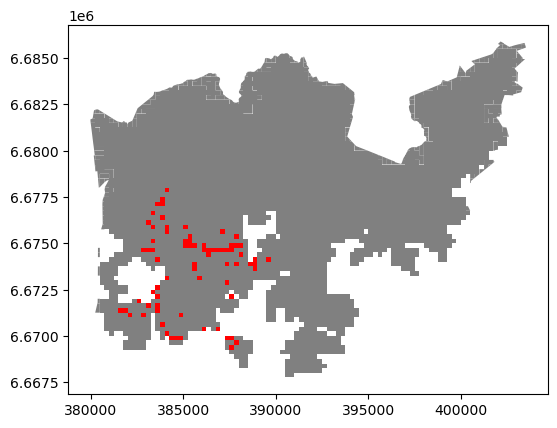

In [10]:
# Plot all grid cells, then all cells that are 15 minutes away
ax = dissolved.plot(facecolor="grey")
selection.plot(ax=ax, facecolor="red")

Another way to visualize the travel times in the entire GeoDataFrame is to plot using one specific column. In order to use our `car_r_t` column, which is now the index of the GeoDataFrame, we need to reset the index:

In [11]:
dissolved = dissolved.reset_index()
dissolved.head()

,car_r_t,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
0,-1,"MULTIPOLYGON (((384750.000 6670000.000, 384500...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
1,0,"POLYGON ((385750.000 6672000.000, 385750.000 6...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
2,7,"POLYGON ((386250.000 6671750.000, 386000.000 6...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
3,8,"MULTIPOLYGON (((386000.000 6671500.000, 385750...",1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
4,9,"MULTIPOLYGON (((385000.000 6671250.000, 385000...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


As we can see, we now have our `car_r_t` as a column again, and can then plot the GeoDataFrame passing this column using the `column` parameter:

<Axes: >

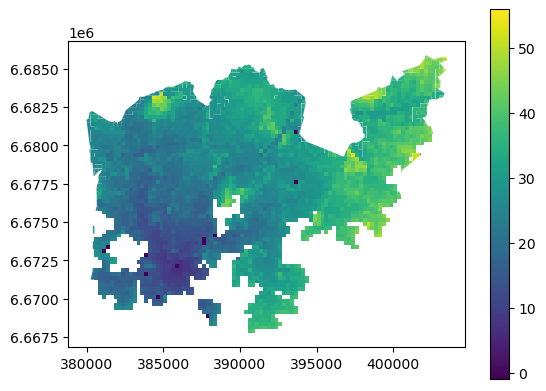

In [13]:
dissolved.plot(column="car_r_t", legend=True)

 ## Practical example: hospital districts
 
 In this tutorial, we will create boundaries of Finnish hospital districts
 (*sairaanhoitopiiri* in Finnish) by dissolving municipality boundaries into
 larger entities. Main processing steps include a table join and dissolving the
 municipality geometries into larger entities.
 
 We will combine information from [municipality
 polygons](https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html)
 from Statistics Finland and a [list of health care
 districts](https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat)
 by the Finnish Municipality authority Kuntaliitto.
 
 
 Importing required python packages:
 
 ```{code-cell}
 import json
 import numpy
 import pandas
 import geopandas
 import pyproj
 import matplotlib.pyplot as plt
 ```
 
 
 ## Read in data
 
 - **Municipality polygons** from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html
     - wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs?
     - feature: `tilastointialueet:kunta1000k` (most recent information about municipality polygons)
 
 ```{code-cell}
 # For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
 url = (
     "http://geo.stat.fi/geoserver/tilastointialueet/wfs"
     "?request=GetFeature"
     "&typename=tilastointialueet:kunta1000k"
     "&outputformat=JSON"
 )
 geodata = geopandas.read_file(url)
 ```
 
 ```{code-cell}
 geodata.head()
 ```
 
 ```{code-cell}
 # Check length (there are 309 municipalities in Finland in 2022)
 len(geodata)
 ```
 
 ```{code-cell}
 #Select and rename columns
 geodata.rename(columns={'kunta':'code'}, inplace=True)
 geodata = geodata[['code','name', 'geometry']]
 geodata.head()
 ```
 
 ```{code-cell}
 geodata.plot()
 ```
 
 ```{code-cell}
 geodata.dtypes
 ```
 
 - **Finnish municipalities with hospital district information** as an Excel spreadsheet 
     - Downloaded from: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat in March 2020. 
     - File `Shp_jäsenkunnat_2020.xls`, sheet `kunnat_shp_2020_ aakkosjärj.` This is the original unaltered file.
     - In this file, "shp" stands for "sairaanhoitopiiri" (hospital district in Finnish)
     
 *Note: this data set does not include Åland (Ahvenanmaa). Åland municipalities are added in the later step.*
 *Note: "hospital districts" is a more proper translation to sairaanhoitopiirit, but in this lesson I use "health care districts" to refer to these entities*
 
 Excel files often come with additional formatting such as metadata on the first lines of the data array. This is why it is a good idea to download the file on your own computer and have a look at the data structure before reading in the file using Python.
 It is also often a good idea to save the file as a csv file before reading in the data. However, it is also possible to read in data directly from Excel. For this, you need to have the xlrd module installed:
 
 ```
 conda install -c conda-forge xlrd
 ```
 
 Now we are ready to read in the data using pandas.
 
 In the case of this health districts excel the header is located on the 4th row (index 3) of the excel spreadsheet.
 
 ```{code-cell}
 # Read in the excel spreadsheet
 data = pd.read_excel(r"data/Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)
 ```
 
 ```{code-cell}
 data.head()
 ```
 
 In addition, the first row after the header is empty. We can get rid of it using the dropna() -function:
 
 ```{code-cell}
 data.dropna(inplace=True)
 ```
 
 Check number of rows (16 Åland municipalities are missing)
 
 ```{code-cell}
 len(data)
 ```
 
 The data needs some fixing and cleaning after reading the excel sheet
 
 ```{code-cell}
 # Rename columns from Finnish to English 
 data.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'}, inplace=True)
 
 # Select only useful columns
 data = data[['code','healthCareDistrict']]
 ```
 
 ```{code-cell}
 data
 ```
 
 Looks better! Now we need to prepare the data for table join. We will use the municipality code as the common key.
 
 ```{code-cell}
 data.dtypes
 ```
 
 The code column is currently a floating point number. We need to modify these codes so that they match the ones in the spatial data:
 
 ```{code-cell}
 # Example using one code
 number = data.at[1, "code"]
 number
 ```
 
 ```{code-cell}
 # Conver this number to character string 020
 print("20".zfill(3))
 ```
 
 Let's apply this process on all rows at once, and take into account different number of digits:
 
 ```{code-cell}
 # Convert to character string
 data["code"] = data["code"].astype(int).astype('str')
 
 # Add missing zeros to municipality codes
 data["code"] = data["code"].str.zfill(3)
 ```
 
 ```{code-cell}
 data.head()
 ```
 
 ## Join Health district info to the municipality polygons
 
 ```{code-cell}
 # Merge health district info to geodata using "code" as the common key
 geodata = geodata.merge(data, on="code", how="left")
 ```
 
 ```{code-cell}
 geodata
 ```
 
 Looks good! However, Municipalities in the Åland island did not have a matching health care district in the data. Let's have a closer look:
 
 ```{code-cell}
 # List all municipalities that lack health district info:
 geodata[geodata["healthCareDistrict"].isnull()].name
 ```
 
 ```{code-cell}
 # Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
 geodata.loc[geodata["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"
 ```
 
 Check the count of municipalities per health care disctrict
 
 ```{code-cell}
 geodata["healthCareDistrict"].value_counts()
 ```
 
 ## Create polygons for health care districts
 
 ```{code-cell}
 # Dissolve (=combine) municipality polygon geometries for each health care district
 districts = geodata.dissolve(by='healthCareDistrict')
 ```
 
 ```{code-cell}
 districts.reset_index(inplace=True)
 ```
 
 ```{code-cell}
 # Select useful columns
 districts = districts[["healthCareDistrict", "geometry"]]
 ```
 
 ```{code-cell}
 districts
 ```
 
 ```{code-cell}
 districts.plot(column='healthCareDistrict', cmap='tab20', k=20)
 plt.axis('off')
 ```
 
 ```{code-cell}
 # Write GeoJSON in original projection
 districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')
 ```
 
 ```{code-cell}
 # Re-project to WGS84 and save again
 wgs84 = CRS.from_epsg(4326)
 districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')
 ```
 
 That's it! You can elaborate this workflow by joining additional data. For example, if you join population info per municipality you can sum it up for each health care district using the `aggfunc=sum` argument to get population count per health care district.